In [1]:
from pystencils.session import *

# Plotting and Animation


## 1) Stencils

This section shows how to visualize stencils, i.e. lists of directions

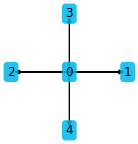

In [2]:
stencil_5pt = [(0, 0), (1, 0), (-1, 0), (0, 1), (0, -1)]
plt.figure(figsize=(2, 2))
ps.stencil.plot(stencil_5pt)

By default the indices are shown the arrow endpoints. 
Custom data can also be plotted:

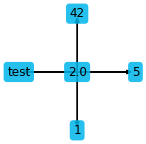

In [3]:
plt.figure(figsize=(2, 2))
ps.stencil.plot(stencil_5pt, data=[2.0, 5, 'test', 42, 1])

The stencil can also be given as an expression in a single field

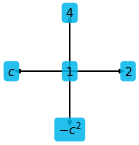

In [4]:
f = ps.fields("f: [2D]")
c = sp.symbols("c")
expr = f[0, 0] + 2 * f[1, 0] + c * f[-1, 0] + 4 * f[0, 1] - c**2 * f[0, -1]
plt.figure(figsize=(2, 2))
ps.stencil.plot_expression(expr)

There is also a function to simply plot sympy expressions depending on one variable only:

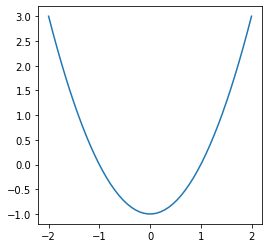

In [5]:
x = sp.symbols("x")
plt.figure(figsize=(4, 4))
plt.sympy_function(x**2 - 1, x_values=np.linspace(-2, 2));

Three dimensional stencils can be visualized in two different ways

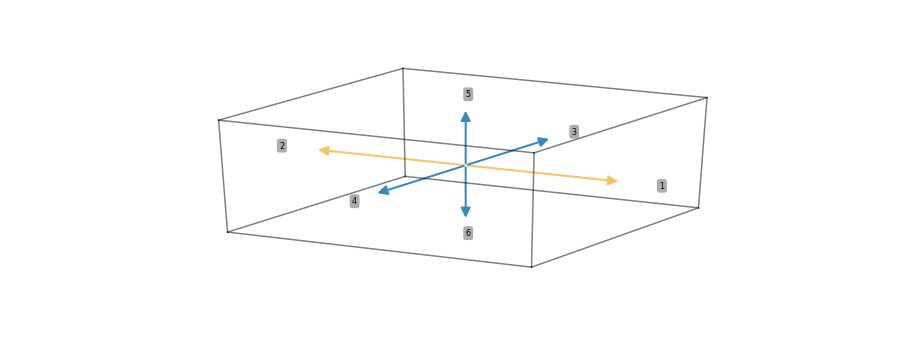

In [6]:
stencil_7pt = [(0, 0, 0), (1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
ps.stencil.plot(stencil_7pt, data=[i for i in range(7)])

This kind of plot works well for small stencils, for larger stencils this gets messy:

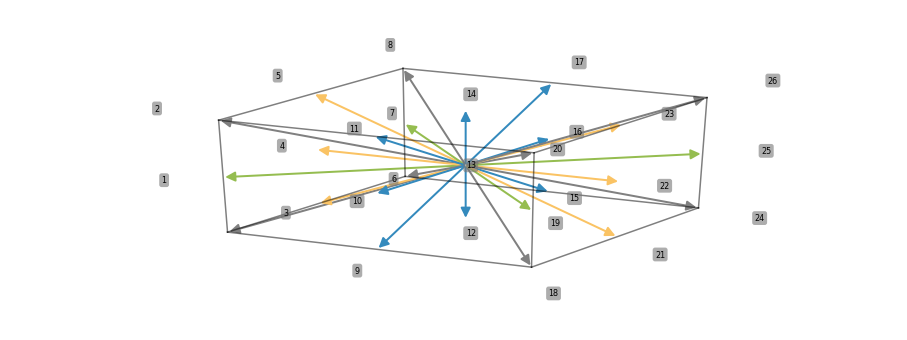

In [7]:
stencil_27pt = [(i, j, k) for i in (-1, 0, 1) for j in (-1, 0, 1) for k in (-1, 0, 1)]
ps.stencil.plot(stencil_27pt, data=[i for i in range(27)])

Adding `slice=True` shows the three projections of the stencils instead

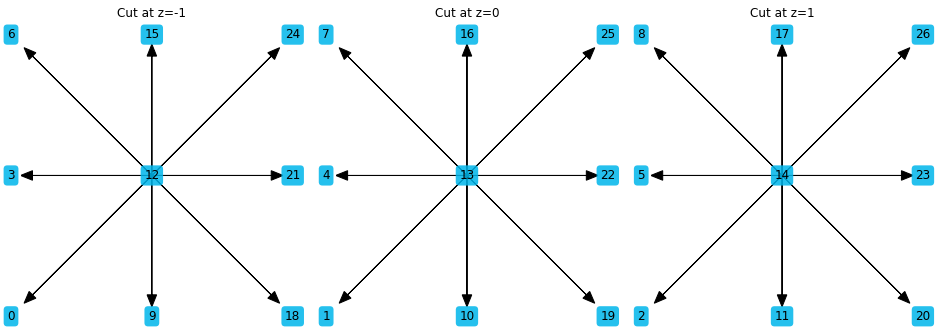

In [8]:
ps.stencil.plot(stencil_27pt, data=[i for i in range(27)], slice=True)

## 2) Scalar fields

*pystencils* also comes with helper functions to plot simulation data. 
The plotting functions are simple but useful wrappers around basic Matplotlib functionality. 
*pystencils* imports all matplotlib functions as well, such that one can use

```import pystencils.plot as plt```

instead of 

```import matplotlib.pyplot as plt```

The session import at the top of the notebook does this already, and also sets up inline plotting for notebooks.

This section demonstrates how to plot 2D scalar fields. Internally `imshow` from matplotlib is used, however the coordinate system is changed such that (0,0) is in the lower left corner,  the $x$-axis points to the right, and the $y$-axis upward. 

The next function returns a scalar field for demonstration

In [9]:
def example_scalar_field(t=0):
    x, y = np.meshgrid(np.linspace(0, 2 * np.pi, 100), np.linspace(0, 2 * np.pi, 100))
    z = np.cos(x + 0.1 * t) * np.sin(y + 0.1 * t) + 0.1 * x * y
    return z

To show a single scalar field use `plt.scalar_field`:

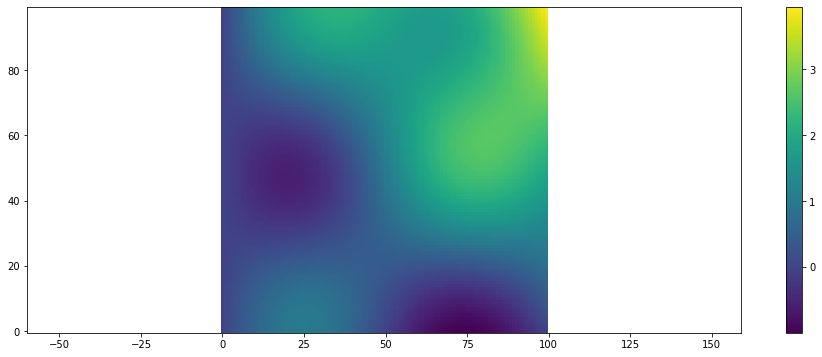

In [10]:
arr = example_scalar_field()
plt.scalar_field(arr)
plt.colorbar();

A similar wrapper around `counter` from matplotlib

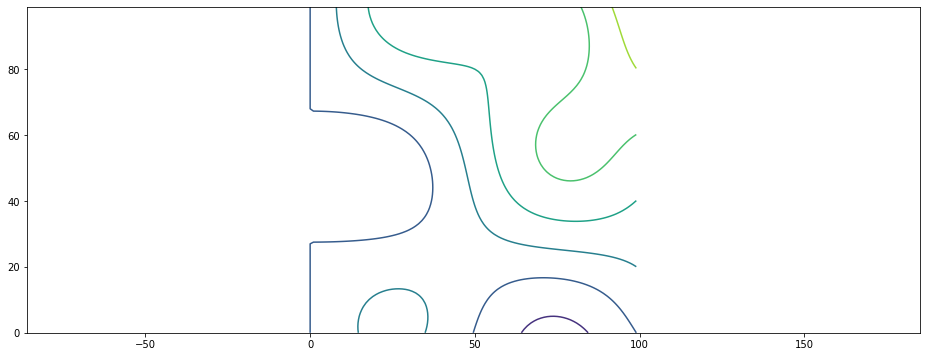

In [11]:
plt.scalar_field_contour(arr);

A 3D surface plot is also possible:

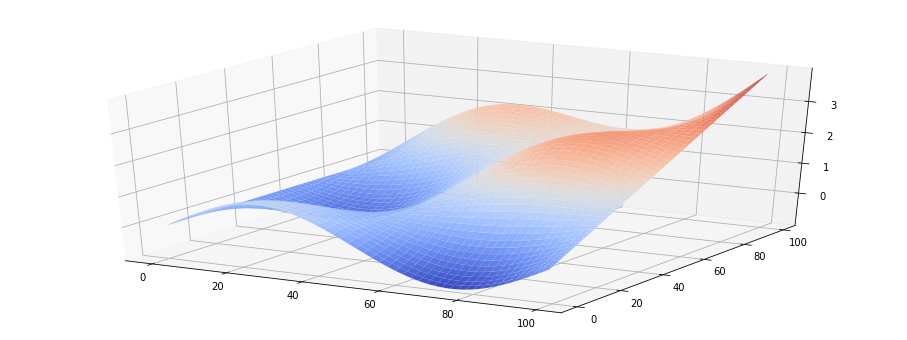

In [12]:
plt.scalar_field_surface(arr)

For simulation results one often needs visualization of time dependent results. To show an evolving scalar field an animation can be created as shown in the next cell

In [13]:
t = 0
def run_func():
    global t
    t += 1
    return example_scalar_field(t)

In [14]:
plt.figure()
animation = plt.scalar_field_animation(run_func, frames=60)
ps.jupyter.display_as_html_video(animation)

Another way to display animations is as an image sequence. While the `run_func` i.e. the simulation is running the current state is then displayed as HTML image. Use this method when your `run_func` takes a long time and you want to see the status while the simulation runs. The `frames` parameter specifies how often the run function will be called.

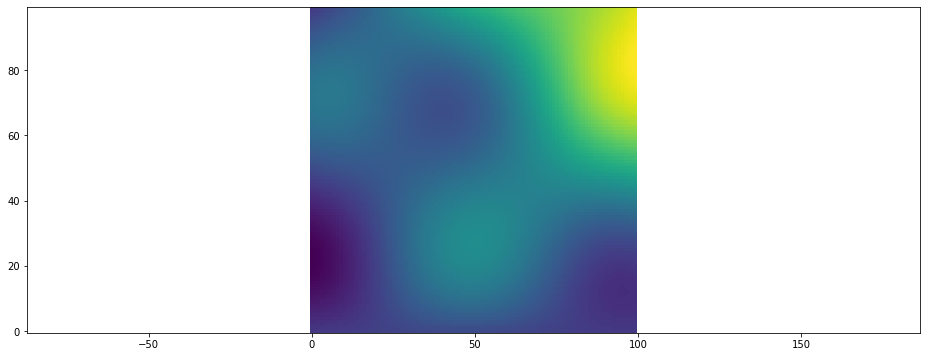

In [15]:
plt.figure()
animation = plt.scalar_field_animation(run_func, frames=30)
ps.jupyter.display_as_html_image(animation)

For surface plots there is also an animated version:

In [16]:
animation = plt.surface_plot_animation(run_func, frames=60)
ps.jupyter.display_as_html_video(animation)

## 3) Vector Fields

*pystencils* provides another set of plotting functions for vector fields, e.g. velocity fields. 
They have three index dimensions, where the last coordinate has to have 2 entries, representing the $x$ and $y$ component of the vector.

In [17]:
def example_vector_field(t=0, shape=(40, 40)):
    result = np.empty(shape + (2,))
    x, y = np.meshgrid(np.linspace(0, 2 * np.pi, shape[0]), np.linspace(0, 2 * np.pi, shape[1]))
    result[..., 0] = np.cos(x + 0.1 * t) * np.sin(y + 0.1 * t) + 0.01 * x * y
    result[..., 1] = np.cos(0.001 * y)
    return result

Vector fields can either be plotted using quivers (arrows)

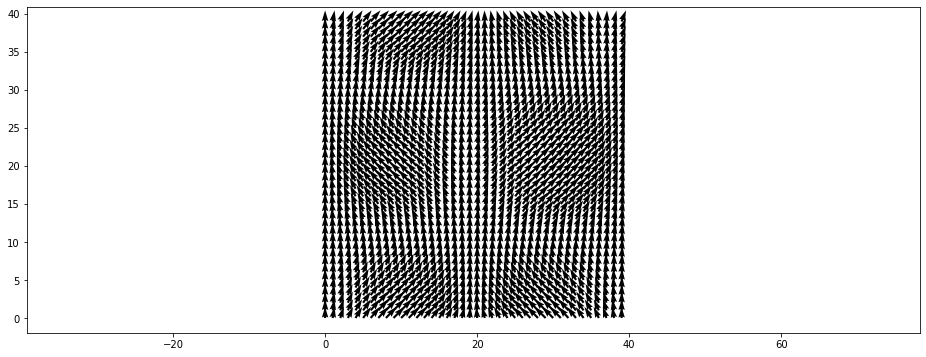

In [18]:
plt.figure()
data = example_vector_field()
plt.vector_field(data, step=1);

The `step` parameter can be used to display only every $n$'th arrow:

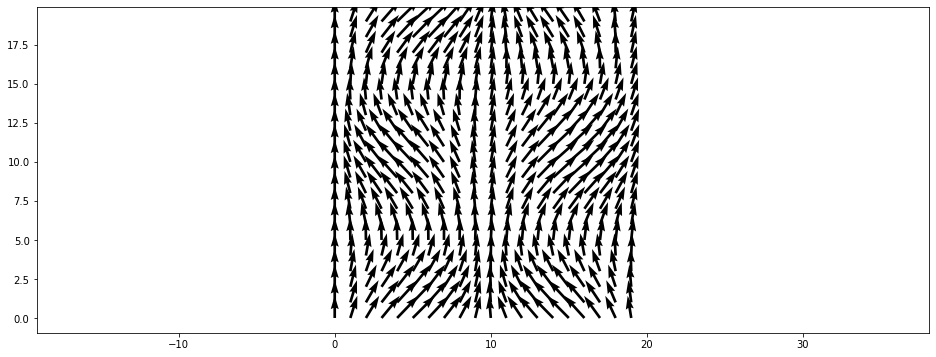

In [19]:
plt.figure()
plt.vector_field(data, step=2);

or by displaying their magnitude in a colormap

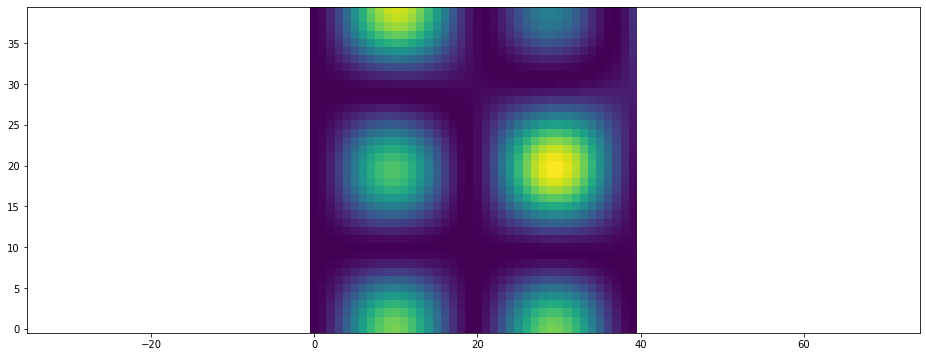

In [20]:
plt.figure()
plt.vector_field_magnitude(data);

There are also functions to animate both variants, quiver plots..

In [21]:
t = 0
def run_func():
    global t
    t += 1
    return example_vector_field(t)

In [22]:
plt.figure()
animation = plt.vector_field_animation(run_func, frames=60)
ps.jupyter.display_as_html_video(animation)

...and magnitude plots

In [23]:
animation = plt.vector_field_magnitude_animation(run_func, frames=60)
ps.jupyter.display_as_html_video(animation)

## 4) Phase Fields

A third group of plotting functions helps to display arrays as they occur in phase-field simulations. However these function may also be useful for other kinds of simulations. 
They expect arrays where the last coordinate indicates the fraction of a certain component, i.e. `arr[x, y, 2]` should be a value between $0$ and $1$ and specifies the fraction of the third phase at $(x, y)$. The plotting functions expect that sum over the last coordinate gives $1$ for all cells.

Lets again generate some example data

In [24]:
def example_phase_field():
    from scipy.ndimage.filters import gaussian_filter

    shape=(80, 80)
    result = np.zeros(shape + (4,))
    result[20:40, 20:40, 0] = 1
    gaussian_filter(result[..., 0], sigma=3, output=result[..., 0])
    result[50:70, 30:50, 1] = 1
    gaussian_filter(result[..., 1], sigma=3, output=result[..., 1])

    result[:, :10, 2] = 1
    result[:, :, 3] = 1 - np.sum(result, axis=2)
    return result
data = example_phase_field()

The `scalar_field_alpha_value` function uses the last entry, i.e. the value between 0 and 1 as alpha value of the specified color to show where the phase is located. This visualization makes it easy to distinguish between smooth and sharp transitions.

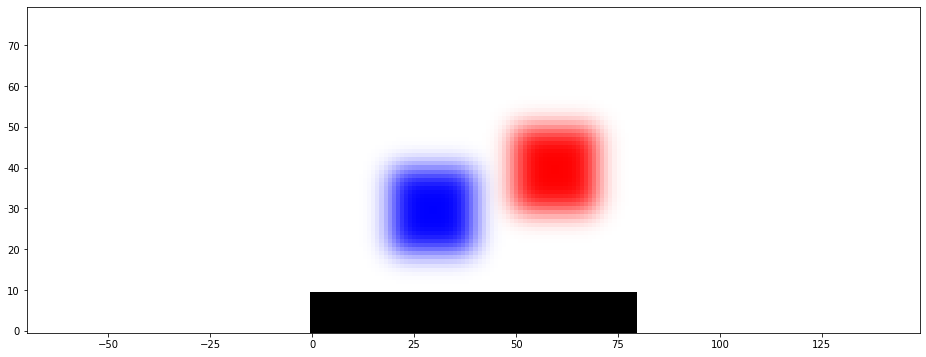

In [25]:
plt.scalar_field_alpha_value(data[..., 0], color='b')
plt.scalar_field_alpha_value(data[..., 1], color='r');
plt.scalar_field_alpha_value(data[..., 2], color='k');

To see all existing phases the `phase_plot` function uses this alpha-value representation for all phases.

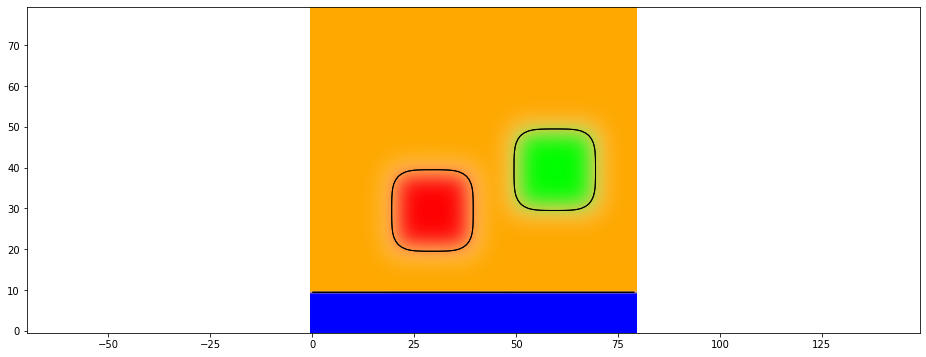

In [26]:
plt.phase_plot(data)

Another option to display each field separately in a subplot

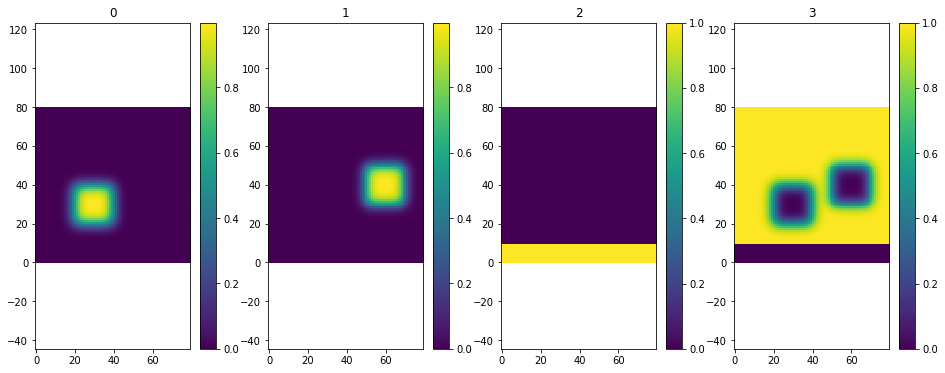

In [27]:
plt.multiple_scalar_fields(data)